<a href="https://colab.research.google.com/github/Christorious/learn/blob/main/Machine_Learning_Beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using synthetic regression data.
Data split into 160 training samples and 40 testing samples.
Initialized RandomForestRegressor for regression.
Model trained and predictions made for regression.


,Metric,Training,Cross-Validation,Test
0,R²,0.993729,0.953005,0.955616
1,MAE,0.662995,1.816019,1.767371


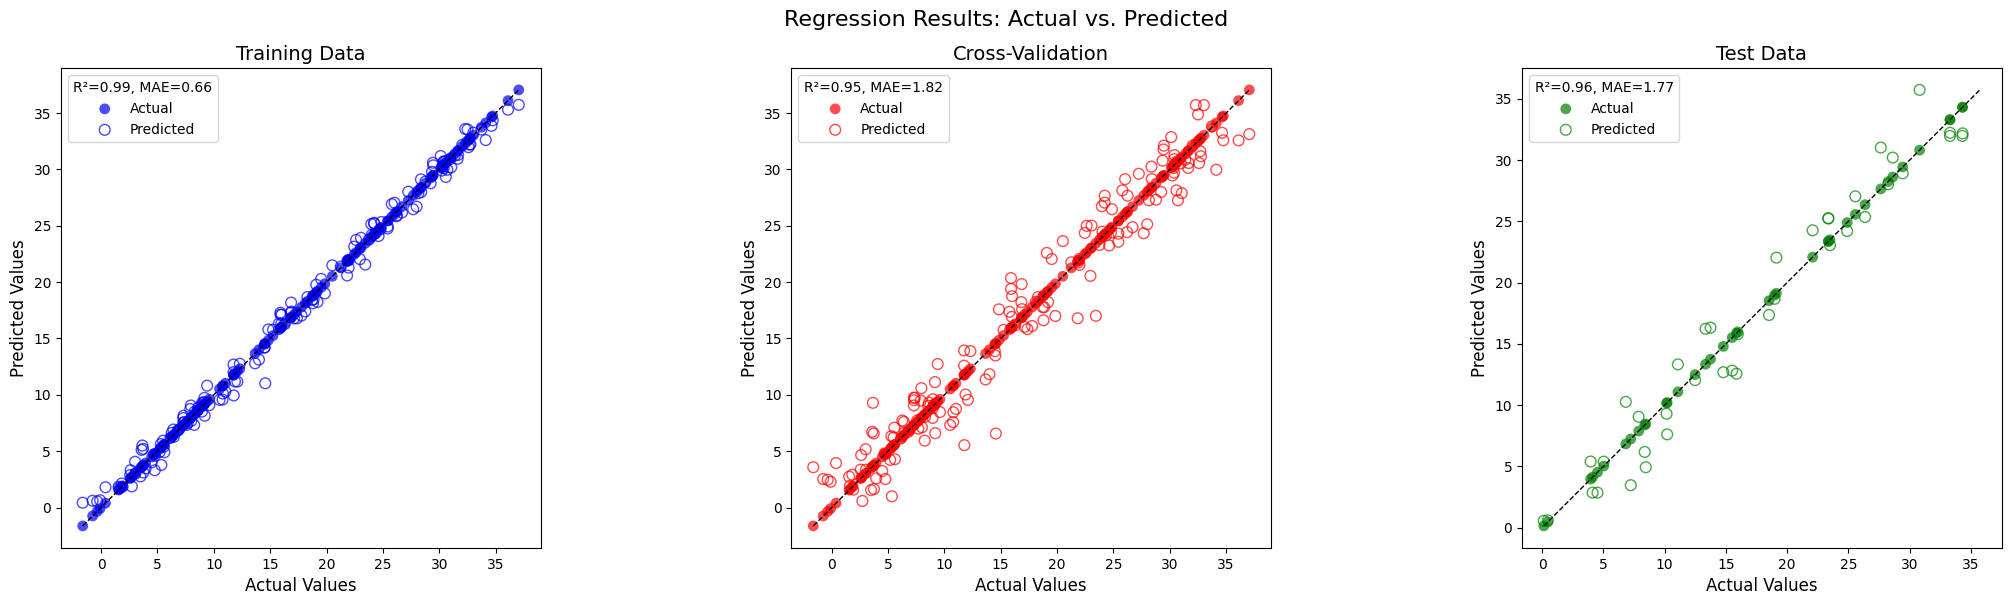


Generating SHAP plots for model explainability...
Displaying SHAP Summary Bar Plot...


<ipython-input-1-00cb585ebd7e>:509: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)


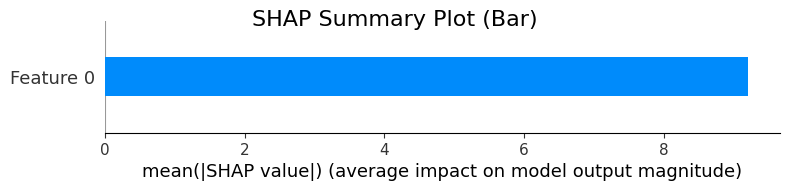

Displaying SHAP Summary Dot Plot...


<ipython-input-1-00cb585ebd7e>:517: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, show=False)


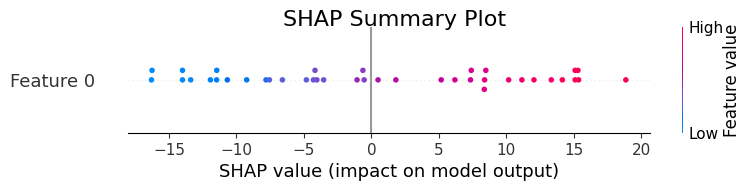

SHAP plot generation complete.

--- Reporting Results ---
Refer to Section 2.3.13 in the tutorial PDF for guidelines on thorough reporting and documentation.
This includes defining scope, detailing data processing, specifying model details,
presenting metrics, comparing models, analyzing errors, evaluating robustness,
using version control, ensuring compliance, outlining limitations, and summarizing findings.
In a practical workflow, you would save metrics, plots, and model artifacts at this stage.

Script execution complete.


In [1]:
# --- Section 1: Setup and Imports ---

# Import necessary libraries for numerical operations, data visualization, and ML tasks
import numpy as np # NumPy for numerical computations and array handling
import matplotlib.pyplot as plt # Matplotlib for plotting graphs and visualizations
import pandas as pd # Pandas for data manipulation and analysis, especially with tables (DataFrames)
import os # OS module for interacting with the operating system, like checking file paths
import shap # SHAP for model explainability (understanding feature contributions)
# If you get a ModuleNotFoundError for 'shap', you need to install it: pip install shap

# Import specific functions and classes from scikit-learn
# These are essential for building and evaluating machine learning models
from sklearn.model_selection import train_test_split, cross_val_predict # Functions for splitting data and cross-validation
from sklearn.metrics import ( # Metrics for evaluating model performance
    mean_absolute_error, r2_score, # Metrics for regression tasks (comparing continuous values)
    accuracy_score, f1_score, # Metrics for classification tasks (checking correct categories)
    silhouette_score, davies_bouldin_score # Metrics for clustering tasks (evaluating group quality)
)
# Corrected import: Removed spaces in RandomForestRegressor and RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier # Ensemble ML models (like using a group of experts)
from sklearn.cluster import KMeans # ML model for clustering (finding groups)

# Import a tool for dimensionality reduction, useful for visualizing high-dimensional data
from sklearn.decomposition import PCA # Principal Component Analysis for reducing data to fewer dimensions

# Import a tool for visualizing classification results
from sklearn.metrics import ConfusionMatrixDisplay # Function to display confusion matrices

# Import a tool for creating complex plot layouts in Matplotlib
from matplotlib.gridspec import GridSpec # Grid specification for arranging subplots

# --- Section 2: Setting a Random Seed ---

# Set a random seed for reproducibility
# This ensures that any random operations (like data splitting or synthetic data generation)
# will produce the same results each time the script is run.
np.random.seed(42) # You can use any integer here, 42 is a common choice.

# --- Section 3: Selecting the ML Task ---

# Choose the ML task you want to perform by setting the value of this variable.
# The rest of the script will adapt based on this choice.
# Options: 'regression', 'classification', or 'clustering'
TASK = 'regression' # Currently set to regression. Change this string to switch tasks.

# --- Section 4: Data Source Toggle ---

# Decide whether to use your own dataset or use synthetic (generated) data
# Set to True if you want to load your own data files (requires files named as specified below)
# Set to False to use the synthetic data generated by the script.
USE_USER_DATA = False # Change to True to load your own data

# --- Section 5: Defining Synthetic Datasets ---

# These are simple datasets generated within the script for demonstration purposes.
# They help illustrate the different ML tasks without needing external files initially.

# Synthetic data for Regression: A simple linear relationship with some random noise.
X_reg_synthetic = np.random.rand(200, 1) * 10 # 200 samples, 1 feature (values between 0 and 10)
y_reg_synthetic = 3.5 * X_reg_synthetic.squeeze() + np.random.randn(200) * 2 # y = 3.5*x + noise

# Synthetic data for Classification: Points in 2D space labeled based on whether their sum is > 1.
X_class_synthetic = np.random.rand(200, 2) # 200 samples, 2 features (values between 0 and 1)
# Binary target (0 or 1) based on a simple condition: feature1 + feature2 > 1
y_class_synthetic = (X_class_synthetic[:, 0] + X_class_synthetic[:, 1] > 1).astype(int)

# Synthetic data for Clustering: Random points scattered in a 2D space.
X_cluster_synthetic = np.random.rand(200, 2) * 10 # 200 samples, 2 features (values between 0 and 10)
# Note: Clustering is unsupervised, so there is no 'y' (target variable) for this dataset.

# --- Section 6: Function to Load User-Provided Data ---

# This function handles loading data from Excel (.xlsx) or CSV (.csv) files.
# It expects the file to be in the same directory as the script.
# For supervised tasks (regression/classification), it assumes the last column is the target.
# For clustering, it assumes all columns are features.
def load_data(file_path, task):
    """
    Load data from an Excel or CSV file.
    Parameters:
        file_path (str): Path to the data file.
        task (str): The task type ('regression', 'classification', 'clustering')
    Returns:
        X (np.ndarray): Features.
        y (np.ndarray or None): Target. None for clustering.
    """
    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File '{file_path}' does not exist in the current directory.")

    # Load data based on file extension
    if file_path.endswith('.xlsx'):
        data = pd.read_excel(file_path)
    elif file_path.endswith('.csv'):
        data = pd.read_csv(file_path)
    else:
        raise ValueError("Unsupported file format. Please provide an Excel (.xlsx) or CSV (.csv) file.")

    # Process data based on the selected task
    if task in ['regression', 'classification']:
        # For supervised tasks, check if there's at least one feature and one target column
        if data.shape[1] < 2:
            raise ValueError("Data must contain at least one feature column and one target column.")
        # All columns except the last are input features (X)
        X = data.iloc[:, :-1].values
        # The last column is the target variable (y)
        y = data.iloc[:, -1].values
    elif task == 'clustering':
        # For clustering (unsupervised), all columns are treated as features (X)
        X = data.values
        # There is no target variable for clustering
        y = None
    else:
        # Handle unsupported task names
        raise ValueError("Unsupported task. Choose from 'regression', 'classification', or 'clustering'.")

    return X, y # Return the features and target (or None for clustering)

# --- Section 7: Utilizing User Data or Synthetic Data ---

# This block decides which data to use based on the USE_USER_DATA flag.
# It also assigns the chosen data to the main X and y variables used later in the script.
if USE_USER_DATA:
    # If using user data, define the expected file paths for each task.
    # You would need to place your actual data files with these names in the same directory.
    if TASK == 'regression':
        data_file = 'regression_dataset.xlsx' # Replace with your actual regression data file name
    elif TASK == 'classification':
        data_file = 'classification_dataset.xlsx' # Replace with your actual classification data file name
    elif TASK == 'clustering':
        data_file = 'clustering_dataset.csv' # Replace with your actual clustering data file name
    else:
        # This case should ideally not be reached if TASK is validated earlier, but included for safety.
        raise ValueError("Unsupported task. Choose from 'regression', 'classification', or 'clustering'.")

    # Attempt to load the user's data using the load_data function
    try:
        X, y = load_data(data_file, TASK) # Load your own data
        print(f"Loaded {TASK} data from '{data_file}'.") # Confirm successful loading
    except Exception as e:
        # If loading fails, print an error and exit the script.
        print(f"Error loading {TASK} data: {e}")
        exit(1) # Exit the program if data loading fails
else:
    # If not using user data, use the synthetic datasets defined earlier.
    if TASK == 'regression':
        X = X_reg_synthetic
        y = y_reg_synthetic
        print("Using synthetic regression data.") # Inform the user which data is being used
    elif TASK == 'classification':
        X = X_class_synthetic
        y = y_class_synthetic
        print("Using synthetic classification data.") # Inform the user
    elif TASK == 'clustering':
        X = X_cluster_synthetic
        y = None # Clustering has no target variable
        print("Using synthetic clustering data.") # Inform the user
    else:
         # This case should ideally not be reached if TASK is validated earlier.
        raise ValueError("Unsupported task. Choose from 'regression', 'classification', or 'clustering'.")

# --- Section 8: Split data into training and test sets (supervised tasks) ---

# This section splits the data for supervised tasks (regression and classification).
# Unsupervised tasks (clustering) use the full dataset for training.
if TASK in ['regression', 'classification']:
    # For regression and classification, split data into training and testing sets
    # train_test_split shuffles the data and splits it into two sets.
    # test_size=0.2 means 20% of the data will be used for testing, and 80% for training.
    # random_state=42 ensures the split is the same every time for reproducibility.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.") # Report the split size
else:
    # For clustering, use all data for training and testing (no target variable needed for split)
    X_train = X
    X_test = X # In clustering, we often evaluate on the same data or new data without labels
    y_train = None # No target for training
    y_test = None # No target for testing
    print(f"Using full dataset ({len(X)} samples) for clustering.") # Report using full data

# --- Section 9: Selecting and Initializing the Model ---

# This block initializes the appropriate machine learning model based on the selected TASK.

# Define the number of clusters for KMeans (only relevant if TASK is 'clustering')
# You might need to determine an optimal number of clusters based on your data.
N_CLUSTERS = 3 # Example: Assuming 3 clusters for the synthetic clustering data

# Initialize the model based on the task
if TASK == 'regression':
    # For regression, use RandomForestRegressor
    # n_estimators is the number of trees in the forest (more trees usually means better performance but slower)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    print(f"Initialized {type(model).__name__} for regression.")
elif TASK == 'classification':
    # For classification, use RandomForestClassifier
    # n_estimators is the number of trees in the forest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    print(f"Initialized {type(model).__name__} for classification.")
elif TASK == 'clustering':
    # For clustering, use KMeans
    # n_clusters is the number of clusters to form
    # random_state for reproducibility of initial cluster centers
    model = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10) # n_init='auto' or an integer
    print(f"Initialized {type(model).__name__} with {N_CLUSTERS} clusters for clustering.")
else:
    # This case should ideally not be reached if TASK is validated earlier.
    raise ValueError("Unsupported task. Cannot initialize model.")

# Note: The tutorial also includes a section for comparing multiple models,
# but for this step-by-step explanation, we focus on the single-model workflow first.
# The COMPARE_ALL flag and get_all_models function are part of that advanced section.
# For now, assume COMPARE_ALL is False.
COMPARE_ALL = False # Assuming we are not comparing all models for this basic walkthrough.
# The get_all_models function would be defined elsewhere in the full script if COMPARE_ALL is True.


# --- Section 10: Training and Testing the Model ---

# This section trains the model and makes predictions.
# For supervised tasks, it also performs cross-validation.

# Check if we are in a single-model workflow (not comparing multiple models)
if not COMPARE_ALL:
    # Single-model workflow
    if TASK in ['regression', 'classification']:
        # For supervised tasks:
        # Perform cross-validation to get predictions on the training data
        # cv=5 means 5-fold cross-validation
        y_cv_pred = cross_val_predict(model, X_train, y_train, cv=5)

        # Train the model on the entire training dataset
        model.fit(X_train, y_train)

        # Make predictions on the training and testing datasets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        print(f"Model trained and predictions made for {TASK}.")

    else: # TASK == 'clustering'
        # For clustering (unsupervised):
        # Fit the KMeans model to the training data (which is the full dataset in this case)
        model.fit(X_train)

        # Predict the cluster labels for the test data (again, the full dataset here)
        cluster_labels = model.predict(X_test)

        print(f"Clustering model fitted and labels predicted.")

# Note: The 'else' block for COMPARE_ALL is for handling multiple models and is not included
# in this basic step-by-step walkthrough, as it's more complex.

# --- Section 11: Calculating Performance Metrics ---

# This section calculates the relevant performance metrics based on the selected TASK.

if TASK == 'regression':
    # Calculate regression metrics (R-squared and Mean Absolute Error)
    metrics = {
        "Metric": ["R²", "MAE"], # Names of the metrics
        "Training": [
            r2_score(y_train, y_train_pred), # R² on training data
            mean_absolute_error(y_train, y_train_pred) # MAE on training data
        ],
        "Cross-Validation": [
            r2_score(y_train, y_cv_pred), # R² from cross-validation predictions
            mean_absolute_error(y_train, y_cv_pred) # MAE from cross-validation predictions
        ],
        "Test": [
            r2_score(y_test, y_test_pred), # R² on test data
            mean_absolute_error(y_test, y_test_pred) # MAE on test data
        ],
    }
    # Create a pandas DataFrame to display metrics in a table format
    metrics_df = pd.DataFrame(metrics)

elif TASK == 'classification':
    # Calculate classification metrics (Accuracy and F1-Score)
    metrics = {
        "Metric": ["Accuracy", "F1-Score"], # Names of the metrics
        "Training": [
            accuracy_score(y_train, model.predict(X_train)), # Accuracy on training data
            f1_score(y_train, model.predict(X_train), average='weighted') # F1-Score on training data (weighted for multi-class)
        ],
        "Cross-Validation": [
            accuracy_score(y_train, y_cv_pred), # Accuracy from cross-validation predictions
            f1_score(y_train, y_cv_pred, average='weighted') # F1-Score from cross-validation predictions
        ],
        "Test": [
            accuracy_score(y_test, y_test_pred), # Accuracy on test data
            f1_score(y_test, y_test_pred, average='weighted') # F1-Score on test data
        ],
    }
    # Create a pandas DataFrame to display metrics
    metrics_df = pd.DataFrame(metrics)

elif TASK == 'clustering':
    # Calculate clustering metrics (Silhouette Score and Davies-Bouldin Index)
    # These metrics evaluate the quality of the clusters found.
    metrics = {
        "Metric": ["Silhouette Score", "Davies-Bouldin Index"], # Names of the metrics
        "Score": [
            silhouette_score(X_test, cluster_labels), # Silhouette Score based on test data and predicted labels
            davies_bouldin_score(X_test, cluster_labels) # Davies-Bouldin Index based on test data and predicted labels
        ],
    }
    # Create a pandas DataFrame to display metrics
    metrics_df = pd.DataFrame(metrics)

else:
    # Handle unsupported task names
    raise ValueError("Unsupported task. Cannot calculate metrics.")

# Display the calculated metrics, styled for better readability if in a suitable environment (like Jupyter)
styled_metrics = metrics_df.style.set_properties(**{'text-align': 'center'})\
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]}, # Center align headers
        {'selector': 'td', 'props': [('text-align', 'center')]} # Center align cells
    ])\
    .set_caption("Model Performance Metrics") # Add a caption to the table

# Try to display the styled table (works well in environments like Jupyter)
try:
    from IPython.display import display # Import display function for Jupyter
    display(styled_metrics) # Display the styled table
except ImportError:
    # If not in a Jupyter-like environment, just print the DataFrame
    print("\nModel Performance Metrics:")
    print(metrics_df)


# --- Section 12: Visualizing Results ---

# This section generates plots to visualize the model's performance and results.

# Function to plot results for supervised tasks (regression and classification)
def plot_results_supervised(ax, y_actual, y_pred, title, color, metric1_name, metric1_value, metric2_name=None, metric2_value=None):
    """
    Plot Actual vs Predicted values for regression or Confusion Matrix for classification.
    Parameters:
        ax (matplotlib.axes.Axes): The axes to plot on.
        y_actual (np.ndarray): Actual target values.
        y_pred (np.ndarray): Predicted target values.
        title (str): Title of the subplot.
        color (str): Color for the plots (used in regression).
        metric1_name (str): Name of the first metric.
        metric1_value (float): Value of the first metric.
        metric2_name (str, optional): Name of the second metric (for regression/classification).
        metric2_value (float, optional): Value of the second metric.
    """
    if TASK == 'regression':
        # Scatter plot for Actual vs Predicted values
        ax.scatter(y_actual, y_actual, color=color, label='Actual', marker='o', s=60, alpha=0.7, edgecolors='none')
        ax.scatter(y_actual, y_pred, facecolors='none', edgecolors=color, label='Predicted', marker='o', s=60, alpha=0.7)

        # Add a dashed line representing the ideal prediction (where Actual == Predicted)
        # Determine the range for the ideal line based on the data
        min_val = min(np.min(y_actual), np.min(y_pred))
        max_val = max(np.max(y_actual), np.max(y_pred))
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1) # 'k--' means black dashed line

        # Set titles and labels
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Actual Values', fontsize=12)
        ax.set_ylabel('Predicted Values', fontsize=12)
        ax.set_aspect('equal', adjustable='box') # Ensure equal scaling on both axes

        # Add a legend with metrics
        legend_text = f'{metric1_name}={metric1_value:.2f}'
        if metric2_name and metric2_value is not None:
             legend_text += f', {metric2_name}={metric2_value:.2f}'
        ax.legend(title=legend_text)

    elif TASK == 'classification':
        # Display a confusion matrix for classification results
        # from_predictions is a convenient function to plot the matrix directly
        ConfusionMatrixDisplay.from_predictions(y_actual, y_pred, ax=ax, cmap='Blues', colorbar=False)
        ax.set_title(title, fontsize=14)

        # Add metrics as a text box on the plot for easy viewing
        metrics_text = f'{metric1_name}={metric1_value:.2f}'
        if metric2_name and metric2_value is not None:
             metrics_text += f'\n{metric2_name}={metric2_value:.2f}' # Use newline for multiple metrics
        ax.text(0.95, 0.05, metrics_text,
                verticalalignment='bottom', horizontalalignment='right',
                transform=ax.transAxes, # Position text relative to the axes
                color='black', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5')) # Add a background box

        # Add grid lines for better readability in the confusion matrix
        ax.grid(True, linestyle='--', linewidth=0.5)

# Generate visualizations based on the selected task
if TASK == 'regression':
    # Create a figure with multiple subplots for regression results
    fig = plt.figure(constrained_layout=True, figsize=(20, 6)) # Define figure size
    # Define a grid layout with 1 row and 3 columns, with spacing
    gs = GridSpec(1, 3, figure=fig, wspace=0.3)

    # Define individual subplots within the grid
    ax1 = fig.add_subplot(gs[0, 0]) # Subplot for Training data
    ax2 = fig.add_subplot(gs[0, 1]) # Subplot for Cross-validation results
    ax3 = fig.add_subplot(gs[0, 2]) # Subplot for Test data

    # Extract the metric values from the metrics_df DataFrame for plotting
    train_r2 = metrics_df.loc[metrics_df['Metric'] == 'R²', 'Training'].values[0]
    train_mae = metrics_df.loc[metrics_df['Metric'] == 'MAE', 'Training'].values[0]
    cv_r2 = metrics_df.loc[metrics_df['Metric'] == 'R²', 'Cross-Validation'].values[0]
    cv_mae = metrics_df.loc[metrics_df['Metric'] == 'MAE', 'Cross-Validation'].values[0]
    test_r2 = metrics_df.loc[metrics_df['Metric'] == 'R²', 'Test'].values[0]
    test_mae = metrics_df.loc[metrics_df['Metric'] == 'MAE', 'Test'].values[0]

    # Plot the results on each subplot using the helper function
    plot_results_supervised(ax1, y_train, y_train_pred, 'Training Data', color='blue', metric1_name='R²', metric1_value=train_r2, metric2_name='MAE', metric2_value=train_mae)
    plot_results_supervised(ax2, y_train, y_cv_pred, 'Cross-Validation', color='red', metric1_name='R²', metric1_value=cv_r2, metric2_name='MAE', metric2_value=cv_mae)
    plot_results_supervised(ax3, y_test, y_test_pred, 'Test Data', color='green', metric1_name='R²', metric1_value=test_r2, metric2_name='MAE', metric2_value=test_mae)

    # Add an overall title to the figure
    fig.suptitle('Regression Results: Actual vs. Predicted', fontsize=16)

    # Display the plots
    plt.show()

elif TASK == 'classification':
    # Create a figure with multiple subplots for classification results (confusion matrices)
    fig = plt.figure(constrained_layout=True, figsize=(20, 6)) # Define figure size
    # Define a grid layout with 1 row and 3 columns, with spacing
    gs = GridSpec(1, 3, figure=fig, wspace=0.3)

    # Define individual subplots within the grid
    ax1 = fig.add_subplot(gs[0, 0]) # Subplot for Training data confusion matrix
    ax2 = fig.add_subplot(gs[0, 1]) # Subplot for Cross-validation confusion matrix
    ax3 = fig.add_subplot(gs[0, 2]) # Subplot for Test data confusion matrix

    # Extract the metric values from the metrics_df DataFrame for plotting
    train_acc = metrics_df.loc[metrics_df['Metric'] == 'Accuracy', 'Training'].values[0]
    train_f1 = metrics_df.loc[metrics_df['Metric'] == 'F1-Score', 'Training'].values[0]
    cv_acc = metrics_df.loc[metrics_df['Metric'] == 'Accuracy', 'Cross-Validation'].values[0]
    cv_f1 = metrics_df.loc[metrics_df['Metric'] == 'F1-Score', 'Cross-Validation'].values[0]
    test_acc = metrics_df.loc[metrics_df['Metric'] == 'Accuracy', 'Test'].values[0]
    test_f1 = metrics_df.loc[metrics_df['Metric'] == 'F1-Score', 'Test'].values[0]

    # Plot the results on each subplot using the helper function
    plot_results_supervised(ax1, y_train, model.predict(X_train), 'Training Data', color='blue', metric1_name='Accuracy', metric1_value=train_acc, metric2_name='F1-Score', metric2_value=train_f1)
    plot_results_supervised(ax2, y_train, y_cv_pred, 'Cross-Validation', color='red', metric1_name='Accuracy', metric1_value=cv_acc, metric2_name='F1-Score', metric2_value=cv_f1)
    plot_results_supervised(ax3, y_test, y_test_pred, 'Test Data', color='green', metric1_name='Accuracy', metric1_value=test_acc, metric2_name='F1-Score', metric2_value=test_f1)

    # Add an overall title to the figure
    fig.suptitle('Classification Results: Confusion Matrices', fontsize=16)

    # Display the plots
    plt.show()

elif TASK == 'clustering':
    # For clustering, visualize the clusters using PCA for dimensionality reduction
    # PCA reduces the number of features while retaining most of the variance.
    # We reduce to 2 components so we can plot on a 2D graph.
    pca = PCA(n_components=2) # Initialize PCA to reduce data to 2 dimensions
    X_pca = pca.fit_transform(X_test) # Fit PCA on the data and transform it

    # Create a figure for clustering results
    fig = plt.figure(constrained_layout=True, figsize=(10, 6)) # Define figure size
    gs = GridSpec(1, 1, figure=fig) # Define a grid layout with 1 row and 1 column
    ax = fig.add_subplot(gs[0, 0]) # Define the single subplot

    # Scatter plot of the PCA-reduced data, colored by the predicted cluster labels
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, edgecolors='k', s=60)

    # Set title and labels
    ax.set_title('Clustering Results (PCA-Reduced Data)', fontsize=16)
    ax.set_xlabel('PCA Component 1', fontsize=12)
    ax.set_ylabel('PCA Component 2', fontsize=12)

    # Create a legend for the clusters
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1) # Add the legend to the plot

    # Add grid lines
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Display the clustering plot
    plt.show()

# --- Section 13: Model Explainability with SHAP (for supervised tasks) ---

# This section uses the SHAP library to help explain the model's predictions.
# SHAP is typically used for supervised learning tasks (regression and classification).
if TASK in ['regression', 'classification']:
    print("\nGenerating SHAP plots for model explainability...")

    # Create a SHAP Explainer object.
    # For tree-based models like RandomForest, shap.TreeExplainer is efficient.
    # For other models, shap.KernelExplainer or shap.LinearExplainer might be used.
    # We use the trained model and the training data (X_train) to build the explainer.
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values for the test dataset (X_test).
    # SHAP values represent the contribution of each feature to the prediction for each instance.
    shap_values = explainer.shap_values(X_test)

    # Generate SHAP summary plots.

    # SHAP Summary Bar Plot: Shows the average absolute impact of each feature on the model output.
    # This gives a global view of feature importance.
    print("Displaying SHAP Summary Bar Plot...")
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.suptitle("SHAP Summary Plot (Bar)", fontsize=16) # Add a title to the plot
    plt.show() # Display the plot

    # SHAP Summary Dot Plot: Shows the distribution of SHAP values for each feature.
    # The color indicates the feature value (e.g., red=high, blue=low).
    # This helps understand how feature values influence the prediction.
    print("Displaying SHAP Summary Dot Plot...")
    shap.summary_plot(shap_values, X_test, show=False)
    plt.suptitle("SHAP Summary Plot", fontsize=16) # Add a title to the plot
    plt.show() # Display the plot

    print("SHAP plot generation complete.")

else:
    # SHAP is not typically used for unsupervised clustering tasks in this manner.
    print("\nSHAP explainability is primarily for supervised tasks (regression/classification).")


# --- Section 14: Reporting Results (Conceptual) ---

# This section is conceptual in the script, referring to the guidelines provided in the paper.
# In a real project, you would implement code to save results, plots, and documentation.

print("\n--- Reporting Results ---")
print("Refer to Section 2.3.13 in the tutorial PDF for guidelines on thorough reporting and documentation.")
print("This includes defining scope, detailing data processing, specifying model details,")
print("presenting metrics, comparing models, analyzing errors, evaluating robustness,")
print("using version control, ensuring compliance, outlining limitations, and summarizing findings.")
print("In a practical workflow, you would save metrics, plots, and model artifacts at this stage.")

print("\nScript execution complete.")

